In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.9'
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental import host_callback
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from functools import partial
import frozen_lake
import plotting
import qlearning
import actions
import mangoenv
import utils
import nets
import optuna

In [2]:
def plot_accuracy_evolution(accuracy_evol, stages_duration):
    def smooth(x, w=0.01):
        filter = jnp.ones(int(1 + w * len(x)))
        smoothed = jnp.convolve(x, filter / filter.sum(), mode="full")
        return smoothed[:len(x)]

    for run_accuracy in accuracy_evol:
        plt.plot(smooth(run_accuracy))

    plt.plot(smooth(accuracy_evol.mean(axis=0)), label="mean", color="black", linewidth=3)
    for stage_duration in jnp.cumsum(jnp.array(stages_duration)):
        plt.axvline(stage_duration, color="red")
    plt.grid()
    plt.ylim(0, 1)
    plt.show()

In [3]:
def setup_env(map_scale, p, rng_key):
    env = frozen_lake.FrozenLake.make_random(rng_key, map_scale, p)
    return env


def setup_replay_buffer(env, rng_key, n_rollouts, rollout_steps):
    episodes = utils.multi_random_rollout(env, rng_key, rollout_steps, n_rollouts)
    replay_buffer = utils.CircularBuffer.store_episodes(episodes)
    return replay_buffer


def setup_dql_state(env, rng_key, lr, map_scale, cell_scale):
    reward_fn = actions.get_reward_fn(cell_scale)
    beta_fn = actions.get_beta_fn(cell_scale)
    qnet = nets.MultiTaskQnet(
        n_actions=env.action_space.n,
        n_comands=5,
        map_shape=(2**map_scale, 2**map_scale),
        cell_shape=(2**cell_scale, 2**cell_scale),
    )
    dql_state = qlearning.MultiDQLTrainState.create(
        rng_key, qnet, env, reward_fn=reward_fn, beta_fn=beta_fn, lr=lr
    )
    return dql_state


def eval_policy(env, dql_state, rng_key, episodes, steps):
    def eval_single(rng_key):
        transitions = dql_state.greedy_rollout(env, rng_key, steps)
        episodes = jnp.clip(transitions.done.sum(), a_min=1)
        rewards = transitions.reward.sum()
        return rewards, episodes

    rewards, episodes = jax.vmap(eval_single)(jax.random.split(rng_key, episodes))
    return rewards.sum() / episodes.sum()


def train_stage(rng_key, env, dql_state, replay_buffer, n_train_iter, batch_size, eval_steps):
    pbar = tqdm(total=n_train_iter, desc="Training")

    def train_step(dql_state, rng_key):
        rng_train, rng_eval = host_callback.id_tap(
            lambda a, t: pbar.update(1), jax.random.split(rng_key)
        )
        dql_state = dql_state.update_params(replay_buffer.sample(rng_train, batch_size))
        accuracy = eval_policy(env, dql_state, rng_eval, episodes=8, steps=eval_steps)
        return dql_state, accuracy

    rng_steps = jax.random.split(rng_key, n_train_iter)
    dql_state, accuracy_evolution = jax.lax.scan(train_step, dql_state, rng_steps)
    return dql_state, accuracy_evolution

In [4]:
def get_objective_fn(map_scale, cell_scales, max_steps, p, train_minicycles=16, n_sims=16):
    multi_env_setup = jax.jit(
        jax.vmap(setup_env, in_axes=(None, None, 0)),
        static_argnames=("map_scale", "p"),
    )
    multi_replay_buffer_setup = jax.jit(
        jax.vmap(setup_replay_buffer, in_axes=(0, 0, None, None)),
        static_argnames=("n_rollouts", "rollout_steps"),
    )
    multi_dql_state_setup = jax.jit(
        jax.vmap(setup_dql_state, in_axes=(0, 0, None, None, None)),
        static_argnames=("lr", "map_scale", "cell_scale"),
    )
    multi_train_stage = jax.jit(
        jax.vmap(train_stage, in_axes=(0, 0, 0, 0, None, None, None)),
        static_argnames=("n_train_iter", "batch_size", "eval_steps"),
    )

    def objective(trial: optuna.Trial) -> jnp.float_:
        # global hyperparameters
        lr = 10 ** trial.suggest_float(f"log_lr", -5, -3, step=0.5)
        batch_size = 2 ** trial.suggest_int("log_batch_size", 10, 10)
        rollout_steps = 2 ** trial.suggest_int("log_rollout_steps", 3, 3)
        total_train_iter = max_steps // batch_size
        train_iter = total_train_iter // train_minicycles
        n_rollouts = train_iter * batch_size // rollout_steps

        # attributes
        seed = trial.number
        trial.set_user_attr("max_steps", max_steps)
        trial.set_user_attr("cycle_train_iter", train_iter)

        # setup rng
        rng_key = jax.random.PRNGKey(seed)
        rng_env, rng_stages = jax.random.split(rng_key, 2)
        rng_env = jax.random.split(rng_env, n_sims)
        rng_stages = jax.random.split(rng_stages, len(cell_scales))

        # sim setup
        train_cycle_budget = train_minicycles
        stages_accuracy = []
        envs = multi_env_setup(map_scale, p, rng_env)

        def run_stage(envs, rng_key, cell_scale, n_cycles, n_rollouts, eval_steps):
            rng_init, rng_cycles = jax.random.split(rng_key)
            rng_init = jax.random.split(rng_init, n_sims)
            rng_cycles = jax.random.split(rng_cycles, n_cycles)

            dql_states = multi_dql_state_setup(envs, rng_init, lr, map_scale, cell_scale)
            cycle_accuracy = []
            for rng_cycle in tqdm(rng_cycles, desc=f"Training {cell_scale}"):
                # setup rngs
                rng_rollout, rng_train = jax.random.split(rng_cycle)
                rng_rollout = jax.random.split(rng_rollout, n_sims)
                rng_train = jax.random.split(rng_train, n_sims)

                # train stage
                replay_buffers = multi_replay_buffer_setup(
                    envs, rng_rollout, n_rollouts, rollout_steps
                )
                dql_states, accuracy_evol = multi_train_stage(
                    rng_train, envs, dql_states, replay_buffers, train_iter, batch_size, eval_steps
                )
                cycle_accuracy.append(accuracy_evol)
            return dql_states, jnp.concatenate(cycle_accuracy, axis=-1)

        for prev_cell_scale, cell_scale, rng_stage in zip(
            [0] + list(cell_scales[:-2]), cell_scales[:-1], rng_stages[:-1]
        ):
            # inner stage hyperparameters
            train_cycles = trial.suggest_int(
                f"train_cycles_{cell_scale}", 1, train_cycle_budget - len(cell_scales)
            )
            train_cycle_budget -= train_cycles
            eval_steps = (2 ** (cell_scale - prev_cell_scale)) ** 2

            # train inner stage
            dql_states, accuracy_evol = run_stage(
                envs, rng_stage, cell_scale, train_cycles, n_rollouts, eval_steps
            )

            # setup next stage and store results
            stages_accuracy.append(accuracy_evol)
            envs = mangoenv.MangoEnv(envs, dql_states, max_steps=eval_steps)
            # n_rollouts = n_rollouts // 4

            # report intermediate results
            # accuracy_evol = jnp.concatenate(stages_accuracy, axis=-1)
            # trial.report(accuracy_evol.mean(), step=accuracy_evol.shape[-1])
            # if trial.should_prune():
            #     raise optuna.TrialPruned()

        # final stage hyperparameters
        prev_cell_scale = ([0] + list(cell_scales))[-2]
        cell_scale = cell_scales[-1]
        rng_stage = rng_stages[-1]
        train_cycles = trial.suggest_int(
            f"train_cycles_{cell_scale}", train_cycle_budget, train_cycle_budget
        )
        eval_steps = (2 ** (cell_scale - prev_cell_scale)) ** 2

        # train final stage
        dql_states, accuracy_evol = run_stage(
            envs, rng_stage, cell_scale, train_cycles, n_rollouts, eval_steps
        )
        stages_accuracy.append(accuracy_evol)

        accuracy_evol = jnp.concatenate(stages_accuracy, axis=-1)
        plot_accuracy_evolution(
            accuracy_evol, [stage_acc.shape[-1] for stage_acc in stages_accuracy]
        )
        trial.set_user_attr(f"accuracy_evol", np.asarray(accuracy_evol).tolist())
        accuracy = (accuracy_evol.mean(axis=0) - accuracy_evol.std(axis=0)).mean()
        return accuracy

    return objective

[I 2024-03-02 06:51:48,807] A new study created in RDB with name: mango


  0%|          | 0/128 [00:00<?, ?it/s]

Training 1:   0%|          | 0/6 [00:00<?, ?it/s]

Random Rollout:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/512 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/4 [00:00<?, ?it/s]

Training 2:   0%|          | 0/5 [00:00<?, ?it/s]

Random Rollout:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/512 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/4 [00:00<?, ?it/s]

Training 3:   0%|          | 0/5 [00:00<?, ?it/s]

Random Rollout:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/512 [00:00<?, ?it/s]

Greedy Rollout:   0%|          | 0/4 [00:00<?, ?it/s]

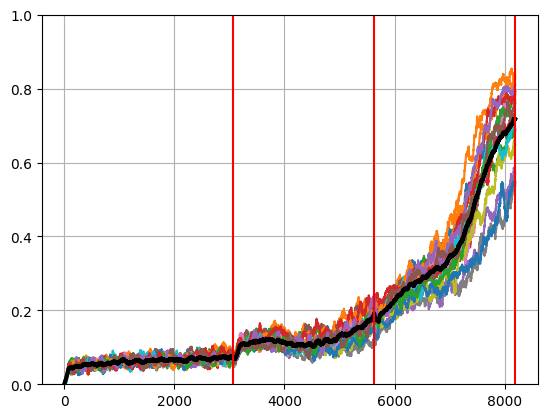

[I 2024-03-02 06:56:06,284] Trial 0 finished with value: 0.07725606858730316 and parameters: {'log_lr': -3.5, 'log_batch_size': 10, 'log_rollout_steps': 3, 'train_cycles_1': 6, 'train_cycles_2': 5, 'train_cycles_3': 5}. Best is trial 0 with value: 0.07725606858730316.


Training 1:   0%|          | 0/3 [00:00<?, ?it/s]

Training 2:   0%|          | 0/2 [00:00<?, ?it/s]

Training 3:   0%|          | 0/11 [00:00<?, ?it/s]

In [5]:
map_scale = 3
cell_scales = (1,2,3,)
p = 0.8
max_steps = 1024*1024*8

storage_path = f"sqlite:///optuna_studies/{2**map_scale}x{2**map_scale}_p_{p}_stages={list(cell_scales)}.db"
study = optuna.create_study(
    study_name=f"mango",
    storage=storage_path,
    load_if_exists=True,
    direction="maximize",
)
study.optimize(
    get_objective_fn(map_scale, cell_scales, max_steps, p),
    n_trials=128,
    show_progress_bar=True,
)

In [ ]:
map_scale = 2
cell_scales = (2,)
storage_path = f"{2**map_scale}x{2**map_scale}_stages={list(cell_scales)}.db"

cmd = f"optuna-dashboard 'sqlite:///optuna_studies/{storage_path}'"
#get_ipython().system(cmd)